# Adjoint Method for Gradient Descent

## Goal
In the final layer of this autoencoder we solve a PDE
governed by parameters $\theta$ and use a loss functional 
$\mathcal{L}$ to compare the solution $u$ to the 
(possibly noisy) observations $u_\text{obs}$ of the 
phenomenon modeled by the PDE.
We would like to use gradient descent to minimize 
$\mathcal{L}$ subject to the constraint of the PDE.
To perform backpropagation we need to compute 
$\frac{d\mathcal{L}}{d\theta}$,
i.e. the gradient of the loss with respect to $\theta$.

We do this via the _adjoint method_. 
In short, the adjoint method requires us to first fix a loss functional,
and then efficiently compute 
$\frac{d\mathcal{L}}{d\theta}$ for any $\theta$.
This is particularly useful when there are many parameters,
in contrast to the tangent linear approach, which 
fixes $\theta$ first then computes the gradient for any loss functional.

## Notation
In what follows the notation for derivative will be contextual.
Let $u$ and $v$ denote functions and $\theta$ denote parameters.
Let $F(u,\theta)$ and $L(u,\theta)$ denote a differential operator 
and a functional, respectively.
The directional derivative of $F$ at the point $u$ in the direction of $v$
will be written as $\frac{\partial F(u)}{\partial v}$ and defined to be

$$
    \frac{\partial F(u)}{\partial v} = \lim_{h \to 0}\frac{F(u+hv) - F(u)}{h}
$$

where $h$ is a scalar.

The functional derivative of $L$ with respect to the function $x$
will be written as $\frac{\partial L}{\partial u}$ and defined to be

$$
    \frac{\partial L}{\partial u} = \lim_{h \to 0}\frac{L(u + h) - L(u)}{h}
$$

where $\lim_{h\to 0}$ means $h$ is a sequence of functions whose $L^1$
norm converges to 0.

## The Adjoint Approach

Let $u$ be the solution to a PDE governed by parameters $\theta$.
Write the PDE as 

\begin{equation}\label{pde}
    F(u,\theta) = 0.
\end{equation}

The above equation makes $u$ an implicit function of $\theta$,
so write $u = u_\theta$.
Now, solving the PDE provides the map $\theta \mapsto u_\theta$,
thus the loss function can be written purely as a function of $\theta$:

$$
    \mathcal{L}(\theta) := L(u_\theta, \theta)
$$

The backpropagation algorithm needs to compute $\frac{d\mathcal{L}}{d\theta}$.
By the chain rule,

$$
    \frac{d\mathcal{L}}{d\theta} = \frac{d}{d\theta} L(u, \theta)
        = \frac{\partial L}{\partial u} \frac{du}{d\theta} + \frac{\partial L}{\partial\theta}.
$$

In the current setting we have the observed data $u_\text{obs}$ 
and we define the $L^2$ loss functional as 
$L(u, \theta) = \| u - u_\text{obs} \|_2^2$,
thus $\frac{\partial L}{\partial\theta} = 0$.
It is straightforward to compute $\frac{\partial L}{\partial u}$, 
but without an analytic solution to \eqref{pde} the term 
$\frac{du}{d\theta}$ is intractable.
__To summarize, the desired gradient is__

\begin{equation}\label{gradient}
    \frac{d\mathcal{L}}{d\theta} = \frac{\partial L}{\partial u} \frac{du}{d\theta}
\end{equation}

__and we need to find an indirect way to compute__ $\frac{du}{d\theta}$.

Let us return to \eqref{pde} and consider its gradient in the direction of $\theta$.
That is, 

$$
\begin{equation}\label{opgrad}
    0 = \frac{d}{d\theta} F(u, \theta) = 
        \frac{\partial F}{\partial u} \frac{du}{d\theta} + \frac{\partial F}{\partial \theta}.
\end{equation}
$$

We will assume $\frac{\partial F}{\partial u}$ is invertible
and solve \eqref{opgrad} for $\frac{du}{d\theta}$ to obtain

$$
    \frac{du}{d\theta} = -\left( \frac{\partial F}{\partial u} \right)^{-1} \frac{\partial F}{\partial \theta}.
$$

Substituting this into \eqref{gradient} gives

$$
    \frac{d\mathcal{L}}{d\theta} 
        = -\frac{\partial L}{\partial u} \left( \frac{\partial F}{\partial u} \right)^{-1} \frac{\partial F}{\partial \theta}.
$$

Taking the conjugate transpose, or adjoint, of the above equation yields

$$
\begin{equation}\label{conjgrad}
    \frac{d\mathcal{L}}{d\theta}^* = -\frac{\partial F}{\partial \theta}^* \left( \frac{\partial F}{\partial u} \right)^{-*} \frac{\partial L}{\partial u}^*.
\end{equation}
$$

Now call $v$ the _adjoint variable associated with_ $u$,
defined to be the solution to the equation

$$
    \frac{\partial F}{\partial u}^{*} v = \frac{\partial L}{\partial u}^*.
$$

Thus, the desired gradient $\frac{d\mathcal{L}}{d\theta}$ 
can be found with the following algorithm:

1. Fix a PDE operator $F(u, \theta)$ and loss functional $\mathcal{L}(\theta) = L(u_\theta, \theta)$
2. Compute $\frac{\partial F}{\partial u}$ and $\frac{\partial L}{\partial u}$
3. Solve the linear system $\frac{\partial F}{\partial u}^* v = \frac{\partial L}{\partial u}^*$ for $v$
4. For any $\theta$ compute $\frac{\partial F}{\partial \theta}$ and use \eqref{conjgrad} to obtain

$$
\boxed{
    \frac{d\mathcal{L}}{d\theta} = -v^* \frac{\partial F}{\partial \theta}
}.
$$

Note the loss gradient is well-defined provided $\frac{\partial F}{\partial u}$ has full rank.

## Example: The constant force Poisson equation

Let's return to the Poisson equation defined in `poisson_encoder_example.ipynb`:

$$
\begin{align*}
    -\Delta u &= c \quad\text{on}\quad [0,1] \\
    u(0) &= u_0 \\
    u(1) &= u_1
\end{align*}
$$

where $\theta = c$ is a constant parameter.
Recall the analytic solution,
which can be seen as an explicit function of $c$, is 

$$
    u_c(x) = -\frac{c}{2} x^2 + \left( \frac{c}{2} + u_1 - u_0 \right) x + u_0.
$$

### Analytic Calculations

#### Direct Gradient
Since we have an analytic solution to the above Poisson equation,
we can compute the loss gradient directly.
Suppose our observation $u_\text{obs}$ depends on 
some fixed true parameter $c_o$ so that
$u_\text{obs} = u_{c_o}$.
We would like to see how the loss functional 
$\mathcal{L}(c) = \| u_c - u_\text{obs} \|_2^2$ 
varies with $c$.
To that end, we readily compute

$$
    \frac{d\mathcal{L}}{dc} 
        = 2 \int_0^1 \! (u - u_\text{obs})\frac{du}{dc}\, dx
        = \frac{c - c_o}{60}.
$$

#### Adjoint Method Gradient
Here we identify $F(u, c) = \Delta u + c$.
Now, $\frac{\partial F}{\partial u}$ is the best linear approximation 
to the (affine linear) operator $F$,
so it follows that $\frac{\partial F}{\partial u} = \Delta$. 
To see this, observe

$$
\begin{align*}
    \frac{\partial F(u, c)}{\partial u} &= \lim_{h \to 0} \frac{F(u + hu, c) - F(u, c)}{h} \\
        &= \lim_{h \to 0} \frac{\Delta(u + hu) + c - \Delta(u) - c}{h} \\
        &= \Delta(u).
\end{align*}
$$

What's more, the Laplacian is known to be self-adjoint, i.e. 
$\frac{\partial F(u, c)}{\partial u} = \frac{\partial F(u, c)}{\partial u}^*$.

The loss derivative is just as straightforward:

$$
    \frac{\partial L}{\partial u} 
        = \frac{\partial}{\partial u} \int_0^1\! (u - u_\text{obs})^2\, dx
        = 2 \int_0^1\! (u - u_\text{obs})\, dx.
$$

Since $\frac{\partial F}{\partial c} = 1$
it is easy to see the loss gradient is

$$
    \frac{d\mathcal{L}}{dc} = -v^*
$$

where $v$ solves $\Delta v = \frac{\partial L}{\partial u}^*$.

### Numerical Implementation

First a brief note on dimensions.
Once we discretize this problem, all the derivatives
have matrix representations.
So let $\theta \in \mathbb{R}^T$ and $u \in \mathbb{R}^U$.
It naturally follows that 
$\frac{\partial F}{\partial u} \in \mathbb{R}^{U\times U}$,
$\frac{\partial F}{\partial \theta}, \frac{du}{d\theta}
\in \mathbb{R}^{U \times T}$,
$\frac{\partial L}{\partial u} \in \mathbb{R}^{1 \times U}$, and
$\frac{d\mathcal{L}}{d\theta} \in \mathbb{R}^{1 \times T}$.

With the analytic calculations complete, let's discretize.
First we pick a resolution $N$ for the domain 
so we have a step size $dx = 1/N$.
This gives a domain partition 
$\{ x_0, \ldots, x_N \}$ where $x_n = \frac{n}{N}$.
Note we have Dirichlet boundary conditions so $U = N - 1$ here.
Using central differences for second derivatives, the Laplacian
becomes a $U \times U$ tridiagonal matrix with entries 
$\frac{(1, -2, 1)}{dx^2}$.

In [ ]:
N = 99      # discretization resolution
dx = 1. / N # step size
U = N - 1   # solution u dimension

# dF/du: discrete Laplacian
diag = [1., -2., 1.]
diag = [x / dx ** 2 for x in diag]
Delta = diags(diag, 
              [-1, 0, 1], 
              (U, U),
              format='csr')

Now let's pick boundary conditions $u_0 = -1$ and $u_1 = 1$ with
ground truth parameter $c_o = 4$ and a guess $c = 2$, 
so that $\frac{d \mathcal{L}}{dc} = -\frac{1}{30}$.

In [ ]:
u0 = -1.    # left boundary value
u1 = 1.     # right boundary value
c_obs = 4.  # ground truth theta
c_hat = 2.  # estimated theta

# compute ground truth u_obs and estimate u_hat
u_obs = np.zeros((U, 1))
u_hat = u_obs.copy()
x = np.linspace(dx, 1. - dx, U)
x = np.reshape(x, u_obs.shape)
# add quadratic, linear, and intercept terms
u_obs += -c_obs / 2 * x ** 2 
u_hat += -c_hat / 2 * x ** 2
u_obs += (c_obs / 2 + u1 - u0) * x
u_hat += (c_hat / 2 + u1 - u0) * x
u_obs += u0
u_hat += u0

Now we simply compute $\frac{\partial L}{\partial u}$ 
and solve $\Delta v = \frac{\partial L}{\partial u}^*$ for $v$,
and dot $v$ with $\frac{\partial F}{\partial c} = 1$.

In [ ]:
# dL/du* has shape U by 1
dLdu_adj = 2. * (u_hat - u_obs) * dx

# solve for the adjoint variable v
v = spsolve(Delta, dLdu_adj)

# dF/dc has shape U by 1
dFdc = np.ones((U, 1))

# grad = -v* dF/dc
gradient = -v.T.dot(dFdc)
print(gradient.item())

Awesome! This is very close to the theoretical gradient of $-1/30$.
Let's use this to converge to the true parameter value
using gradient descent algorithm:
$$
    c_\text{new} = c_\text{old} - \gamma \frac{d\mathcal{L}}{dc}
$$
for some learning rate $\gamma$.
For convenience, I've wrapped the above code into a
class named `autoencoder.adjoint.Poisson`.
We initialize the class by providing the true parameter
and boundary values, then call the `plot_gradient_descent`
method with an initial guess at $\theta$, the learning rate $\gamma$,
and some acceptable distance from the truth to end the descent.

In [ ]:
from autoencoder.adjoint import Poisson
pois_grad = Poisson(theta=4., u0=-1., u1=1.)
pois_grad.plot_gradient_descent(theta_init=2., gamma=10., tol=1e-4)

Just for fun, let's bump the learning rate up by an order of magnitude.
We should expect faster convergence, but also overshooting the optimum.

In [ ]:
pois_grad.plot_gradient_descent(2., 100., 1e-4)

## Bonus Example: learning the boundary conditions

Thus far we have assumed the boundary values $u_0$ and $u_1$ are known.
But what if we let them vary?
Well, at no point in the derivation of the adjoint method did we 
need $F$ to be a _differential_ operator. 
So let's rewrite $F$ as a system of operator equations:

$$
\begin{align*}
    F(u, c) &= \Delta u + c \\
    F_0(u, u_0) &= \left( u_0 - u_\text{obs}(0) \right)^2 \\
    F_1(u, u_1) &= \left( u_1 - u_\text{obs}(1) \right)^2
\end{align*}
$$

For $i=1,2$ we can apply the limit definition 
of the derviative to compute 
$\frac{\partial F_i}{\partial u} = 2(u_i - u_\text{obs}(i))$.
We also update the loss functional with mass on the boundary:
$$
    L(u, \theta) = \| u - u_\text{obs} \|^2_2 + ( u_0 - u_\text{obs}(0) )^2 + ( u_1 - u_\text{obs}(1) )^2
$$

Note this does not change the loss in the discrete setting.
What does change is we have two more equations to solve for the
two additional values of the adjoint variable associated with $u$:

$$
\begin{align*}
    v_i &= \frac{2}{u_i} \int_0^1\! (u - u_\text{obs})\, dx, \quad i=1,2
\end{align*}
$$

Since $\frac{\partial F_i}{\partial u_i} = -1$ we can easily compute
the loss gradient:

$$
    \frac{d\mathcal{L}}{d\theta} = (-v^*, v_0^*, v_1^*)
$$

where $v^*$ is the same as before.

In [1]:
# notebook dependencies
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

In [ ]:
from autoencoder.adjoint import Poisson

pois_grad_bc = Poisson([4., 1., -1.])
pois_grad_bc.get_gradient([2., 1., -1.])

In [ ]:
pois_grad_bc.plot_gradient_descent([2., -1., 1.], 0.1, 1e-2)

In [2]:
N = 99      # discretization resolution
dx = 1. / N # step size
U = N - 1   # solution u dimension

theta_true = np.array([4., 1., -1.])  # ground truth
theta_hat = np.array([2., -1., 1.])   # guesstimates

# dF/du: discrete Laplacian
diag = [-1., 2., -1.]
diag = [x / dx ** 2 for x in diag]
Lap = diags(diag, 
            [-1, 0, 1], 
            (U, U),
            format='csr').toarray()
Lap = np.array(Lap)

In [3]:
# compute ground truth u_obs and estimate u_hat
def solver(theta):
    x = np.linspace(0, 1., U).reshape(U, 1)
    soln = x.copy()
    c, u0, u1 = theta.flatten()
    # add quadratic, linear, and intercept terms
    soln += -c / 2 * x ** 2 
    soln += (c / 2 + u1 - u0) * x
    soln += u0
    assert soln.shape == (U, 1)
    return soln
data = solver(theta_true)
u = solver(theta_hat)

In [4]:
# do gradient descent 
def gradient(theta_hat, theta_true):
    u = solver(theta_hat)
    data = solver(theta_true)
    # dL/du* has shape U by 1
    dJdu = u - data
    
    # solve for the adjoint variable lambda
    lamb = np.linalg.solve(Lap, dJdu)
    
    # now that we have lambda, solve for mu0 and mu1
    mu0 = -lamb[0] / dx
    mu1 = -lamb[-1] / dx
    
    # now dJ/dtheta = lambda* dF/dtheta + mu* dG/dtheta
    #               = (lambda*, -mu0*, -mu1*)
    dFdtheta = np.zeros((U, 3))
    dFdtheta[:,0] = 1.
    
    dGdtheta = np.zeros((1,3))
    dGdtheta[:,1] = -mu0
    dGdtheta[:,2] = -mu1
    
    dJdtheta = lamb.T.dot(dFdtheta) + dGdtheta
    return dJdtheta

In [32]:
theta_true = np.array([4., 1., -1.])  # ground truth
theta_hat = np.array([2., -1., 1.])   # guesstimates
theta_new = theta_hat.reshape(1,3)
gamma = 0.25
tol = 1e-4 # stop when gradient change is below this
theta_diff = np.abs(theta_new - theta_true)
max_iter = 400
its = 0
thetas = []
while its < max_iter and tol < theta_diff.all():
    thetas.append(theta_new.copy())
    gradJ = gradient(theta_new, theta_true)
    if its < 10:
        print(len(thetas))
        print(thetas[0:1])
        print(theta_new)
    theta_new -= gamma * gradJ
    theta_diff = np.abs(theta_new - theta_true)
    its += 1
    total_grad = np.sum(np.abs(gradJ))

1
[array([[ 2., -1.,  1.]])]
[[ 2. -1.  1.]]
2
[array([[ 2., -1.,  1.]])]
[[ 2.40820577 -0.89709813  0.93791871]]
3
[array([[ 2., -1.,  1.]])]
[[ 2.69100364 -0.80429     0.87254853]]
4
[array([[ 2., -1.,  1.]])]
[[ 2.88778915 -0.71932751  0.8058569 ]]
5
[array([[ 2., -1.,  1.]])]
[[ 3.02557027 -0.64063119  0.7391542 ]]
6
[array([[ 2., -1.,  1.]])]
[[ 3.12286269 -0.56708152  0.67330195]]
7
[array([[ 2., -1.,  1.]])]
[[ 3.19236031 -0.49787584  0.60885545]]
8
[array([[ 2., -1.,  1.]])]
[[ 3.24276585 -0.43243013  0.54616158]]
9
[array([[ 2., -1.,  1.]])]
[[ 3.28004594 -0.37031167  0.48542566]]
10
[array([[ 2., -1.,  1.]])]
[[ 3.30829145 -0.31119282  0.42675737]]


In [37]:
thetas

array([[ 2.        , -1.        ,  1.        ],
       [ 2.40820577, -0.89709813,  0.93791871],
       [ 2.69100364, -0.80429   ,  0.87254853],
       ...,
       [ 3.99651932,  1.00032178, -0.999678  ],
       [ 3.99656591,  1.00031747, -0.99968232],
       [ 3.99661188,  1.00031323, -0.99968657]])

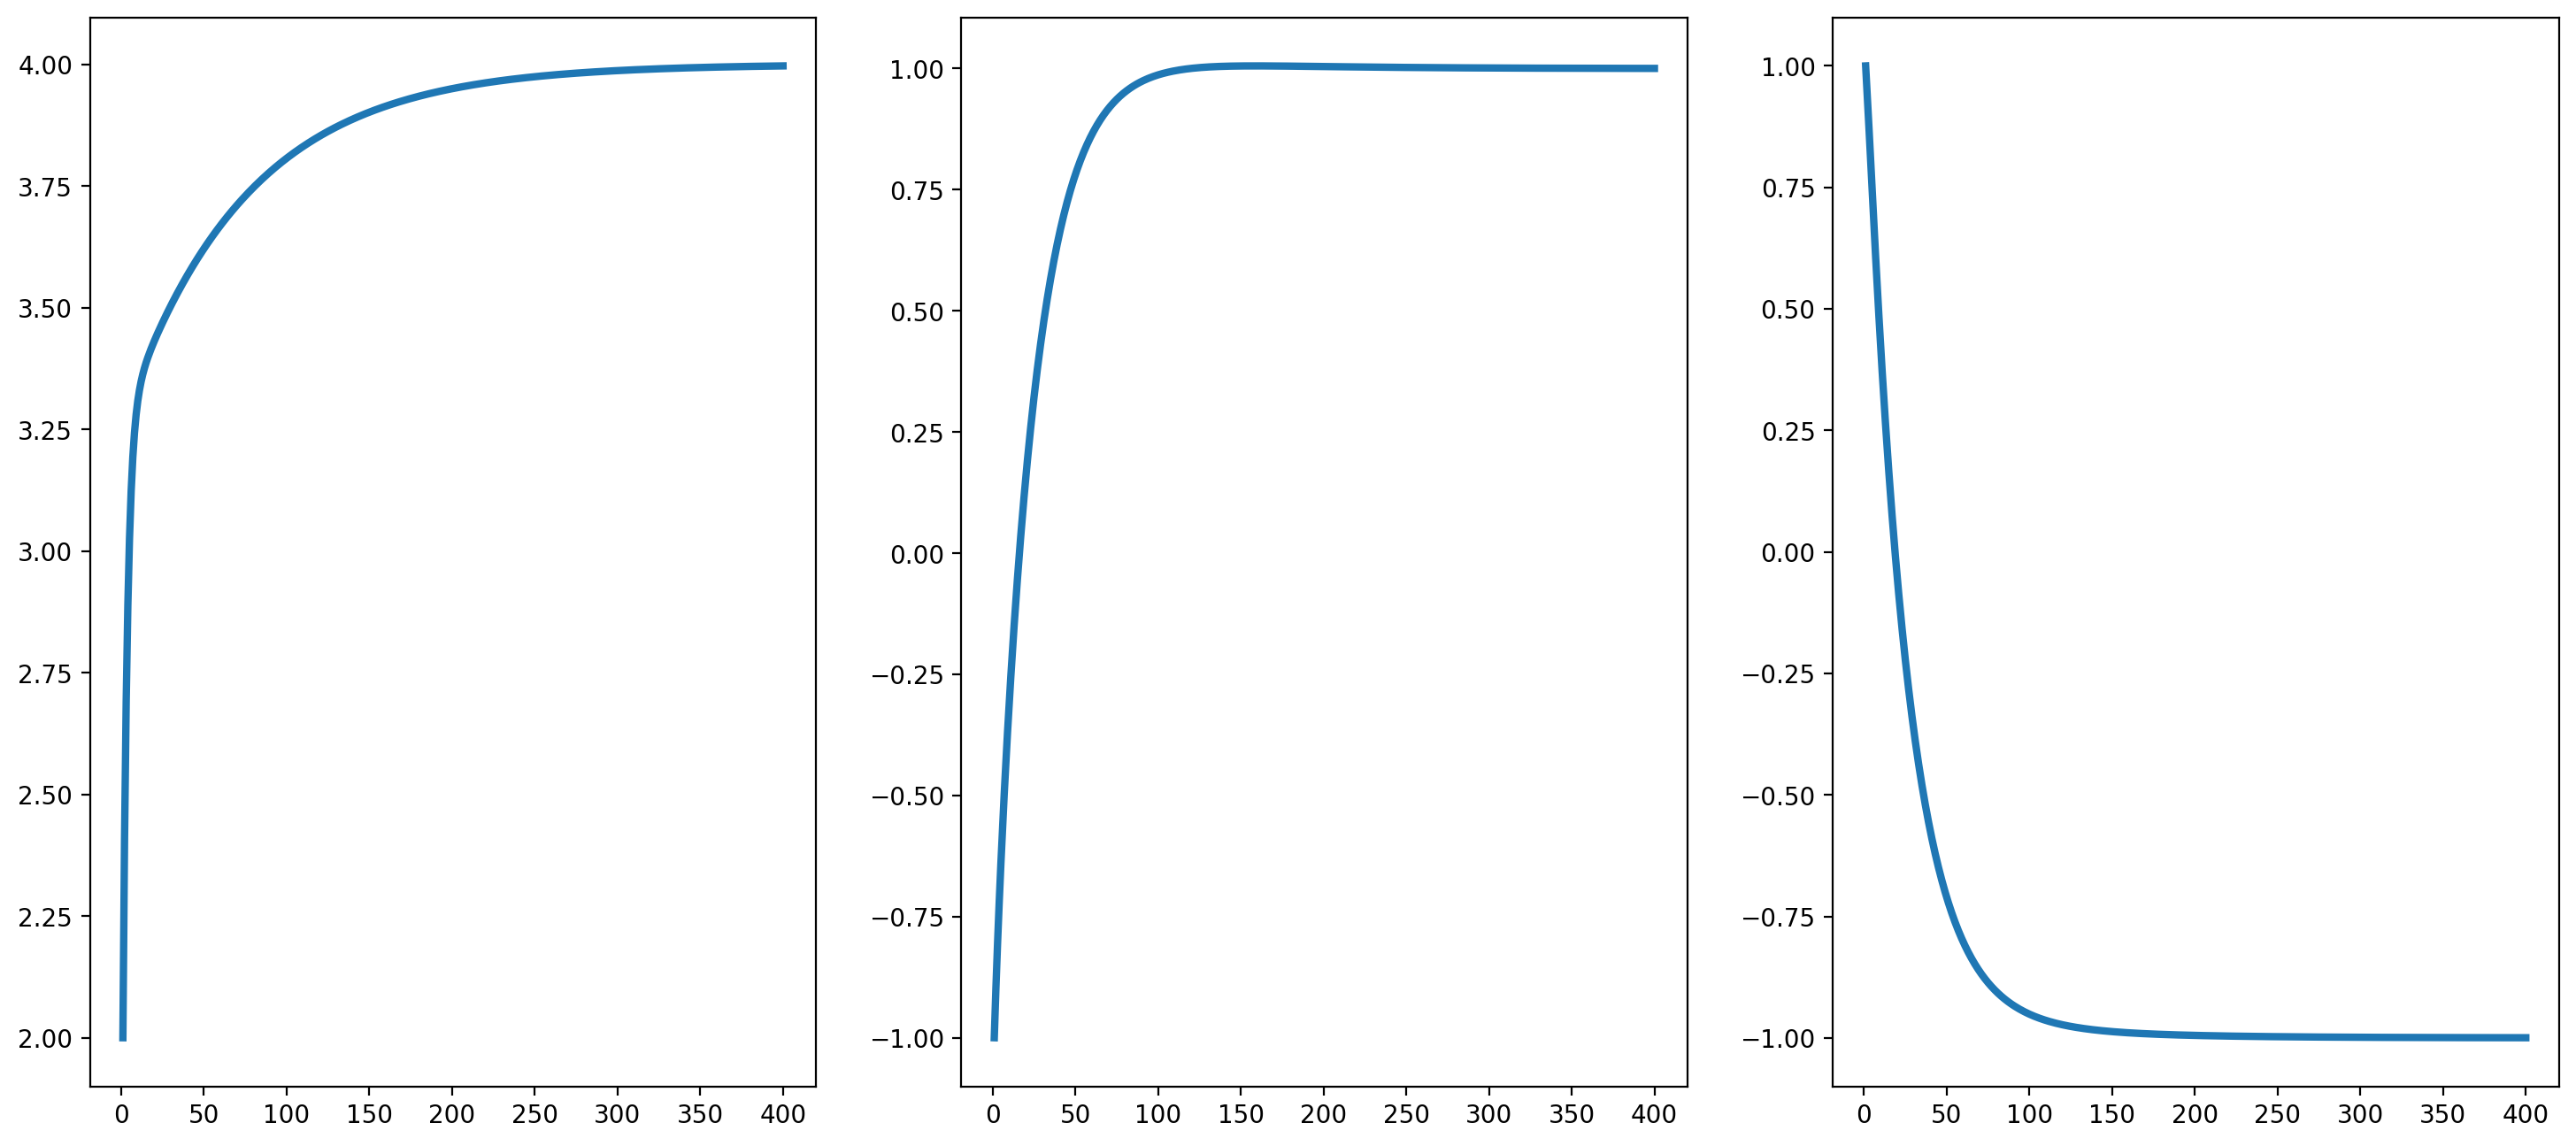

In [36]:
# plot the descent
thetas = np.squeeze(np.array(thetas))
fig, ax = plt.subplots(1, 3, figsize=(18,8), dpi=200)
indices = [x + 1 for x in range(thetas.shape[0])]
for i in range(3):
    ax[i].plot(indices, thetas[:,i], linewidth=3)
plt.show()
plt.close()

In [40]:
thetas[0:3]

array([[ 3.99985006,  1.00001387, -0.99998613],
       [ 3.99985006,  1.00001387, -0.99998613],
       [ 3.99985006,  1.00001387, -0.99998613]])

When $\theta = (c, u_1)$ a direct calculation yields
$$
    \frac{d\mathcal{L}}{d\theta} = 
        \begin{pmatrix}
            1/60 & 1/12 \\ 1/12 & 8/3
        \end{pmatrix}
        \begin{pmatrix}
            c - c' \\ u_1 - u_1'
        \end{pmatrix}
$$

In [10]:
# direct gradient descent
theta_prime = np.array([4.0, -1.0])
theta = np.array([2.0, -1.0])
def gradient(theta, theta_prime):
    theta_diff = theta - theta_prime
    coefs1 = np.array([1./60, 1./12])
    coefs2 = np.array([1./12, 8./3])
    dLdt1 = coefs1.dot(theta_diff)
    dLdt2 = coefs2.dot(theta_diff)
    gradient = np.array([dLdt1, dLdt2])
    return gradient

In [ ]:
gamma = 0.6
theta_new = theta
print('theta', theta_new)
for _ in range(300):
    gradL = gradient(theta_new, theta_prime)
    theta_new -= gamma * gradL
    print('theta', theta_new)

When $\theta = (c, u_0, u_1)$ a direct calculation yields

$$
    \frac{d\mathcal{L}}{d\theta} = 
        \begin{pmatrix}
            1/60 & 1/12 & 1/12 \\ 1/12 &  8/3 & 1/3 \\ 1/12 & 1/3 & 8/3
        \end{pmatrix}
        \begin{pmatrix}
            c - c' \\ u_0 - u_0' \\ u_1 - u_1'
        \end{pmatrix}
$$

In [ ]:
# direct gradient descent
theta_prime = np.array([4.0, 1.0, -1.0])
theta = np.array([2.0, -1.0, 1.0])
def gradient(theta, theta_prime):
    theta_diff = theta - theta_prime
    coefs = np.array([[1./60, 1./12, 1./12], 
                      [1./12, 8./3, 1./3], 
                      [1./12, 1./3, 8./3]])
    gradient = coefs.dot(theta_diff)
    return gradient

gamma = 0.5
theta_new = theta
print('theta', theta_new)
for _ in range(100):
    gradL = gradient(theta_new, theta_prime)
    if _ == 0: print('grad', gradL)
    theta_new -= gamma * gradL
    print('theta', theta_new)